In [ ]:
# # Installations
# %pip install ultralytics
# !pip list | grep tensorflow
# %pip install tensorflow==2.15.0
# %pip install numpy==1.23.5
# !pip list | grep numpy

In [10]:
import cv2
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
%matplotlib inline


## Prepare frames

You can choose to save all frames in a given video but this would give you too many images to handle. So keep a skip rate to save only a few frames.


In [42]:
def save_frames(filename, folder, frame_step=15):
    cap = cv2.VideoCapture(filename)
    filename, _ = os.path.splitext(os.path.basename(filename))
    skip = frame_step
    while cap.isOpened():
        
        (ret, frame) = cap.read()
        if ret == True:
            if skip != 1:
                skip -= 1
                continue
            if skip == 1:
                skip = frame_step
            cv2.imwrite(folder + filename + '_' + str(int(cap.get(cv2.CAP_PROP_POS_FRAMES)))+'.jpg', frame)
        else:
            break 


In [307]:
!rm -rf frames
!mkdir frames

filename = 'data/Athlete running on beach -4K Copyright Free Stock Video-.mp4'
save_frames(filename=filename, folder='frames/')

filename = 'data/Tom Cruise Likes to Run.mp4'
save_frames(filename=filename, folder='frames/')

filename = 'data/Female Standard Walk - Grid Overlay. Animation Reference Body Mechanics.mp4'
save_frames(filename=filename, folder='frames/')

filename = 'data/Larger Male Standard Walk - Grid Overlay. Animation Reference Body Mechanics.mp4'
save_frames(filename=filename, folder='frames/')

filename = 'data/Seth MacFarlane Impersonates Kermit the Frog - The Graham Norton Show.mp4'
save_frames(filename=filename, folder='frames/')

filename = 'data/Seth MacFarlane sings Family Guy karaoke - The Graham Norton Show Series 17 Episode 10 - BBC.mp4'
save_frames(filename=filename, folder='frames/')

filename = 'data/‘The Big Bang Theory’ Cast Is ‘Falling Apart’.mp4'
save_frames(filename=filename, folder='frames/')

filename = 'data/Modern Family Cast on First Impressions of Each Other and Growing Up on the Show -FULL INTERVIEW-.mp4'
save_frames(filename=filename, folder='frames/')

filename = 'data/Modern Family cast reflects on shows impact before 11th and final season.mp4'
save_frames(filename=filename, folder='frames/')

In [13]:
!rm -rf frames2
!mkdir frames2

filename = 'data/Legendary Sprint Speeds In Football.mp4'
save_frames(filename=filename, folder='frames2/')

## Run YOLOv8 on the dataset CLI

yolo predictions are saved in a folder called runs that will be automatically created in the current directory


In [33]:
# !rm -rf runs

In [34]:
!yolo pose predict model=yolov8n-pose.pt source='frames/' save_crop=False save_conf=True save=True save_txt=False

WARNING ⚠️ user config directory is not writeable, defaulting to '/tmp/Ultralytics'.
2023-12-20 12:14:53.270120: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-20 12:14:53.270391: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-20 12:14:53.298371: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Ultralytics YOLOv8.0.116 🚀 Python-3.9.16 torch-2.0.0+cu117 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)
YOLOv8n-pose summary (fused): 187 layers, 3289964 parameters, 0 gradients, 9.2 GFLOPs

image 1/419 /mnt/e/Personal/EXP/action_detection/frames/Athlete running on beach -4K Copyrig

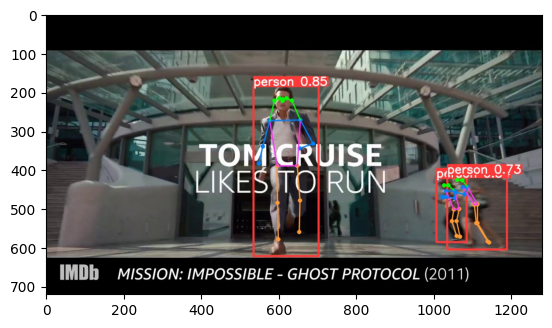

In [38]:
img = cv2.imread('runs/pose/predict/Tom Cruise Likes to Run_31.jpg')
plt.imshow(img[:,:,::-1])

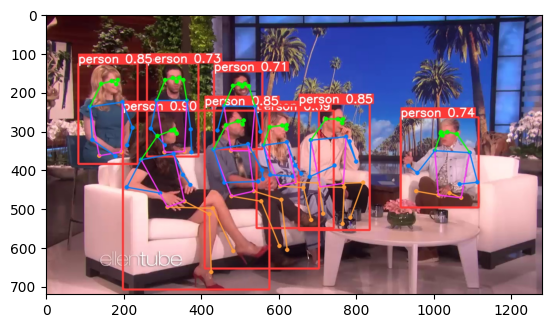

In [41]:
img = cv2.imread('runs/pose/predict/‘The Big Bang Theory’ Cast Is ‘Falling Apart’_15.jpg')
plt.imshow(img[:,:,::-1])

## YOLOv8 python

In [2]:
from ultralytics import YOLO

pose_model = YOLO('yolov8n-pose.pt')


In [3]:
# Define COCO keypoints mapping
coco_mapping = {
    0: "nose",
    1: "left_eye",
    2: "right_eye",
    3: "left_ear",
    4: "right_ear",
    5: "left_shoulder",
    6: "right_shoulder",
    7: "left_elbow",
    8: "right_elbow",
    9: "left_wrist",
    10: "right_wrist",
    11: "left_hip",
    12: "right_hip",
    13: "left_knee",
    14: "right_knee",
    15: "left_ankle",
    16: "right_ankle"
}

def get_coco_keypoints(array):
    coco_keypoints = {}

    for i in range(len(array)):
        x, y, v = array[i]
        keypoint_name = coco_mapping[i]
        coco_keypoints[keypoint_name] = float(x), float(y), float(v)

    return coco_keypoints

In order to perform pose classification you woud have to save the pose keypoints of every person in every frame in a controlled manner where you save teh cropped image of a with a unique file name and save the pose keypoints along with the this unique file name in a dataframe. 

In [22]:
!rm -rf cropped
!mkdir cropped

def get_cropped_persons(folder, df=pd.DataFrame()):
    for file in os.listdir(folder):
        image_path = os.path.join(folder, file)
        img = cv2.imread(image_path)
        results = pose_model(img)

        boxes = results[0].boxes
        masks = results[0].masks
        kpts = results[0].keypoints

        persons = []
        for i, (person, box) in enumerate(zip(kpts.data, boxes.data)):
            coco_keypoints = get_coco_keypoints(person)
            persons.append(coco_keypoints)
            x1, y1, x2, y2, conf, _ = box
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            crop = img[y1:y2, x1:x2]
            basename, ext = os.path.splitext(os.path.basename(image_path))
            new_filename = basename + '_' + str(i) + ext
            cv2.imwrite('cropped/' + new_filename, crop)

            center_x = (x1 + x2) / 2
            center_y = (y1 + y2) / 2
            w = x2 - x1
            h = y2 - y1
            
            person_info = dict()
            person_info['filename'] = new_filename
            for part, (x, y, v) in coco_keypoints.items():
                rel_x = (x - center_x) / w
                rel_y = (y - center_y) / h
                part_info = {
                    f'{part}_x': rel_x,
                    f'{part}_y': rel_y,
                    f'{part}_v': v
                }
                person_info.update(part_info)
            new_row = pd.DataFrame(person_info, index=[0])
            df = pd.concat([df, new_row], ignore_index=True)
    
    return df

In [ ]:
df = get_cropped_persons('frames', df=pd.DataFrame())
df2 = get_cropped_persons('frames2', df=pd.DataFrame())
df.to_csv('annotations.csv', index=False)
df2.to_csv('annotations2.csv', index=False)

Now that the pose of every person in every frame is saved in a dataframe and the cropped image of every person in every frame is saved in a folder `cropped` you can create new folder for every class of pose you want to classify.

In this case I have considered 3 classes of poses: `sitting`, `standing` and `running`.

You can visually inspect the cropped images and move them to the respective folders.


In [6]:
sitting = os.listdir('sitting')
standing = os.listdir('standing') + os.listdir('walking')
running = os.listdir('running')
print(len(sitting), len(standing), len(running), sum([len(sitting), len(standing), len(running)]))

427 338 312 1077


Now we have to remove those rows from the dataframe which were not classified into any of the pose classes and save only those rows which were classified into one of the pose classes.

In [8]:
annotations = pd.read_csv('annotations.csv')
annotations2 = pd.read_csv('annotations2.csv')
annotations = pd.concat([annotations, annotations2], ignore_index=True)
print(len(annotations))
annotations = annotations[annotations['filename'].isin(standing + sitting + running)]
print(len(annotations))

annotations['label'] = annotations['filename'].apply(lambda x: 'standing' if x in standing else 'sitting' if x in sitting else 'running')
annotations['label'].value_counts()

4435
1077


sitting     427
standing    338
running     312
Name: label, dtype: int64

In [9]:
annotations.drop(columns=['filename'], inplace=True)
annotations.to_csv('training_data.csv', index=False)

## Train Classifier

Train a classified using the dataframe generated above

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D

# Assuming df is your DataFrame
df = pd.read_csv('training_data.csv')
X = df.iloc[:, :-1].values  # Features
y = LabelEncoder().fit_transform(df['label'])  # Labels

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model architecture
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X.shape[1], 1)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))  # Assuming 3 classes (sitting, standing, running)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training
history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test))

# Evaluation
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Epoch 1/40
27/27 [==============================] - 1s 19ms/step - loss: 1.0206 - accuracy: 0.5180 - val_loss: 0.8615 - val_accuracy: 0.6944
Epoch 2/40
27/27 [==============================] - 0s 9ms/step - loss: 0.8458 - accuracy: 0.6434 - val_loss: 0.6972 - val_accuracy: 0.7731
Epoch 3/40
27/27 [==============================] - 0s 8ms/step - loss: 0.6732 - accuracy: 0.7666 - val_loss: 0.5442 - val_accuracy: 0.8194
Epoch 4/40
27/27 [==============================] - 0s 9ms/step - loss: 0.5423 - accuracy: 0.7793 - val_loss: 0.4304 - val_accuracy: 0.8657
Epoch 5/40
27/27 [==============================] - 0s 8ms/step - loss: 0.4646 - accuracy: 0.8339 - val_loss: 0.4689 - val_accuracy: 0.8148
Epoch 6/40
27/27 [==============================] - 0s 8ms/step - loss: 0.4325 - accuracy: 0.8246 - val_loss: 0.3473 - val_accuracy: 0.8843
Epoch 7/40
27/27 [==============================] - 0s 8ms/step - loss: 0.3782 - accuracy: 0.8420 - val_loss: 0.3402 - val_accuracy: 0.8750
Epoch 8/40
27/27 [=

In [8]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")

# Save the model
model.save('pose-classifier.h5')

1/7 [===>..........................] - ETA: 0s - loss: 0.1972 - accuracy: 0.8750

7/7 [==============================] - 0s 3ms/step - loss: 0.2014 - accuracy: 0.9120
Loss: 0.20136550068855286, Accuracy: 0.9120370149612427


/home/kevin/miniconda3/envs/passport/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Make a note of the class mapping which will be required later for predictions

In [9]:
label_encoder = LabelEncoder()
encoded_labels  = LabelEncoder().fit_transform(df['label'])  # Labels
class_mapping = {label: idx for label, idx in zip(df['label'], encoded_labels)}
class_mapping

{'running': 0, 'standing': 2, 'sitting': 1}

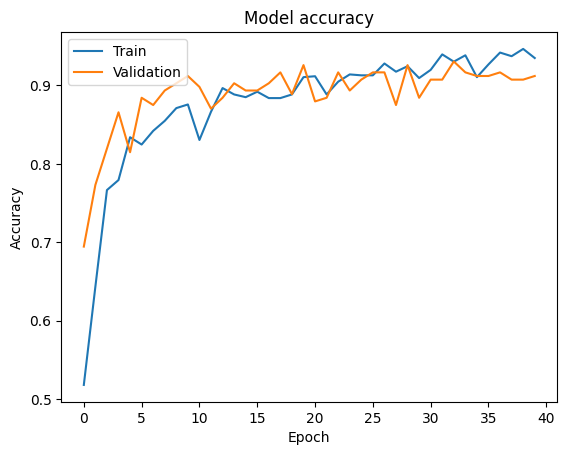

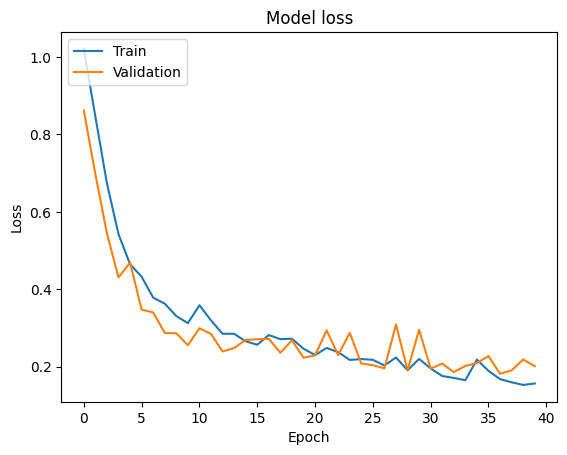

In [10]:
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Call the function with your training history
plot_training_history(history)

## Inference

In [6]:
from tensorflow.keras.models import load_model
clf = load_model("pose-classifier.h5")

def predict_pose(new_data):
    predictions = clf.predict(new_data, verbose=0)
    predicted_class_index = predictions.argmax()
    class_mapping = {0: 'running', 1: 'sitting', 2: 'standing'}
    predicted_class = class_mapping[predicted_class_index]
    return predicted_class


0: 384x640 1 person, 111.4ms
Speed: 3.8ms preprocess, 111.4ms inference, 13.3ms postprocess per image at shape (1, 3, 640, 640)


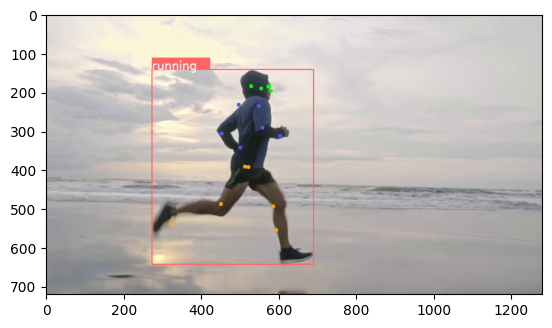

In [74]:
def process_frame(img):
    results = pose_model(img)
    boxes = results[0].boxes
    kpts = results[0].keypoints

    persons = []
    for i, (person, box) in enumerate(zip(kpts.data, boxes.data)):
        coco_keypoints = get_coco_keypoints(person)
        persons.append(coco_keypoints)
        x1, y1, x2, y2, conf, _ = box
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

        center_x = (x1 + x2) / 2
        center_y = (y1 + y2) / 2
        w = x2 - x1
        h = y2 - y1
        
        person_info = dict()
        for part, (x, y, v) in coco_keypoints.items():
            rel_x = (x - center_x) / w
            rel_y = (y - center_y) / h
            part_info = {
                f'{part}_x': rel_x,
                f'{part}_y': rel_y,
                f'{part}_v': v
            }
            # draw a dot on the keypoints
            if 'nose' in part or 'eye' in part or 'ear' in part:
                cv2.circle(img, (int(x), int(y)), 5, (0, 255, 0), -1)
            if 'shoulder' in part or 'elbow' in part or 'wrist' in part:
                cv2.circle(img, (int(x), int(y)), 5, (255, 85, 85), -1)
            if 'hip' in part or 'knee' in part or 'ankle' in part:
                cv2.circle(img, (int(x), int(y)), 5, (0, 165, 255), -1)
            
            person_info.update(part_info)
        
        if person_info['left_knee_v'] < 0.5 and person_info['right_knee_v'] < 0.5:
            pass
        elif w > h:
            pass
        else:
            pred = predict_pose(np.array([list(person_info.values())]))
            cv2.rectangle(img, (x1, y1), (x2, y2), (100, 100, 255), 2)
            cv2.rectangle(img, (x1, y1-30), (x1+150, y1), (100, 100, 255), -1)
            cv2.putText(img, pred, (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    return img

image_path = 'frames/Athlete running on beach -4K Copyright Free Stock Video-_159.jpg'
img = cv2.imread(image_path)
img = process_frame(img)
plt.imshow(img[:, :, ::-1]);

0: 384x640 1 person, 121.4ms
Speed: 10.1ms preprocess, 121.4ms inference, 26.7ms postprocess per image at shape (1, 3, 640, 640)


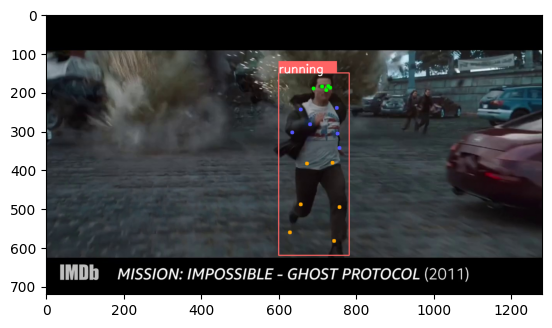

In [76]:
image_path = 'files/original_image.jpg'
img = cv2.imread(image_path)
img = process_frame(img)
cv2.imwrite('files/processed_image.jpg', img)
plt.imshow(img[:, :, ::-1]);


## Process a video

Generate a video with the predictions

Choose an appropriate skip rate to generate a video of a reasonable size

In [68]:
!rm -rf output
!mkdir output

def process_video(filename, output_filename, frame_step=1):
    cap = cv2.VideoCapture(filename)
    fps = cap.get(cv2.CAP_PROP_FPS)
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    out = cv2.VideoWriter(output_filename, fourcc, fps, (int(cap.get(3)), int(cap.get(4))))
    skip = frame_step
    while cap.isOpened():
        (ret, frame) = cap.read()
        if ret == True:
            if skip != 1:
                skip -= 1
                continue
            if skip == 1:
                skip = frame_step
                frame = process_frame(frame)
                out.write(frame)            
        else:
            break
    out.release()
    cap.release()

filename = 'data/graham norton.mp4'
process_video(filename=filename, output_filename='output/graham norton.mp4', frame_step=1)


# filename = 'data/merged.mp4'
# process_video(filename=filename, output_filename='output/tom cruise.mp4', frame_step=1)

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'

0: 384x640 1 person, 117.8ms
Speed: 13.9ms preprocess, 117.8ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 38.4ms
Speed: 3.8ms preprocess, 38.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 47.5ms
Speed: 2.4ms preprocess, 47.5ms inference, 9.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 12.4ms
Speed: 2.2ms preprocess, 12.4ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 11.4ms
Speed: 2.6ms preprocess, 11.4ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 11.0ms
Speed: 2.7ms preprocess, 11.0ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 3

Use an Online tool to compress this video and perhaps convert it to a gif